# Load the Required Liberaries

In [ ]:
import numpy as np
import scipy as sp
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from tqdm import tqdm, trange
from Simulation import Simulation, KeyGenerator

# General Plotting Setting

In [ ]:
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12, 
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 10
})

# Utils - Functions

In [3]:
def calc_phi(n):
    return (n**3 - n**2 - n + 2) / (n**2 + 2*n + 1)

In [4]:
def convert_to_list(x):
    if isinstance(x, list):
        return x
    else:
        return [x]

In [5]:
def run_sim_network(theta_i, theta_nsim, theta_list, connect_prob, phi):
    theta_list = np.array([theta_i, 0.0] + [i for i in theta_list])
    n = len(theta_list)
    matrix_key = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            matrix_key[i, j] = 0 if np.random.rand() > connect_prob else 1
            matrix_key[j, i] = matrix_key[i, j]

    matrix_key[0, 1] = 0
    matrix_key[1, 0] = 0    

    n_link = matrix_key.sum() / 2

    key0 = KeyGenerator.create_key_from_matrix(matrix_key)
    key1 = tuple([1] + [i for i in key0[1:]])
    result = []

    sim = Simulation(alpha=n, gamma=n-1, phi = phi, n = n)

    for rho in np.linspace(1e-3, 1.0, theta_nsim):
        sim.sim_dict = dict()
        theta_j = rho * theta_i
        theta_list[1] = theta_j
        sim.types = theta_list.copy()
        sim.Theta = np.diag(sim.types.reshape(-1))

        sim.simulate_key(key0)
        sim.simulate_key(key1)

        row_res =  [
            theta_i,
            rho,
            theta_j,

            sim.sim_dict[key0]['e'] [0], 
            sim.sim_dict[key1]['e'] [0], 
            sim.sim_dict[key0]['pi'][0], 
            sim.sim_dict[key1]['pi'][0],
            'i', n_link, phi
        ]
        result.append(row_res)

        row_res =  [
            theta_i,
            rho,
            theta_j,

            sim.sim_dict[key0]['e'] [1], 
            sim.sim_dict[key1]['e'] [1], 
            sim.sim_dict[key0]['pi'][1], 
            sim.sim_dict[key1]['pi'][1],
            'j', n_link, phi
        ]
        result.append(row_res)
    
    return result

In [6]:
def run_sum(setting: dict, n_sim: int = 100):
    dist_param_list = convert_to_list(setting['dist_params']) # list of tuples of (alpha, beta) for beta distribution
    n_firms_list = convert_to_list(setting['n_firms'])
    theta_i_list = convert_to_list(setting['theta_i'])
    connect_prob_list = convert_to_list(setting['connect_prob'])
    theta_nsim = setting.get('theta_nsim', 10)

    setting_list = []
    for dist_param in dist_param_list:
        for n_firms in n_firms_list:
            for theta_i in theta_i_list:
                for connect_prob in connect_prob_list:
                    setting_list.append((
                        dist_param, n_firms, theta_i, connect_prob
                    ))

    results = []
    for dist_param, n_firms, theta_i, connect_prob in tqdm(setting_list):
        phi = calc_phi(n_firms)
        alpha, beta = dist_param
        for _ in trange(n_sim, leave=False):
            theta_list = np.random.beta(alpha, beta, size=n_firms - 2)
            result = run_sim_network(theta_i, theta_nsim, theta_list, connect_prob, phi)
            
            for row in result:
                row_full = [(alpha, beta), n_firms, connect_prob] + row
                results.append(row_full)

    df =  pd.DataFrame(results, columns=[
        'dist', 'n_firms', 'Pr(connect)',
        'theta_i', 'theta', 'theta_j',
        'e0', 'e1', 'pi0', 'pi1',
        'firm', 'n_link', 'phi'
    ])
    df['e_diff'] = ((df['e1'] / df['e0']) - 1) * 100
    df['pi_diff'] = ((df['pi1'] / df['pi0']) - 1) * 100
    return df

# Figure 1 
Percentage changes in profit after forming an R\&D collaboration link

In [ ]:
setting = {
    'dist_params': [(0.5, 0.5), (1, 1), (2, 2)],
    'n_firms': 20,
    'theta_i': [1.0],
    'connect_prob': [0.0, 0.25, 0.75, 1.0],
    'theta_nsim': 20
}
df_fig1 = run_sum(setting, n_sim=1_000)
df_fig1

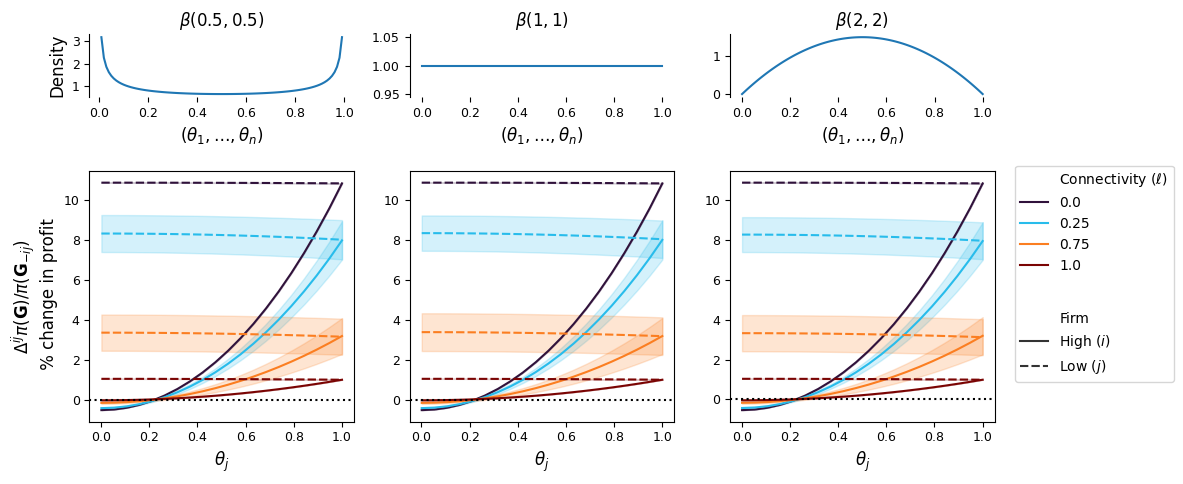

In [12]:
connectivity_text = 'Connectivity ($\ell$)'
firm_text = '\n\nFirm'

df_fig1[connectivity_text] = df_fig1['Pr(connect)']
df_fig1[firm_text] = df_fig1['firm'].map({'i': 'High ($i$)', 'j': 'Low ($j$)'})

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), gridspec_kw={'height_ratios': [1, 4]})

for i, ((alpha, beta), df_sub) in enumerate(df_fig1.groupby('dist')):
    x = np.linspace(0, 1, 100)
    y = sp.stats.beta.pdf(x, a=alpha, b=beta)
    sns.lineplot(x=x, y=y, ax=axs[0, i])
    axs[0, i].set_title(f'$\\beta({alpha}, {beta})$')
    axs[0, i].set_xlabel('$(\\theta_1, \\ldots, \\theta_n)$')

    sns.lineplot(
        data=df_sub, 
        x='theta', y='pi_diff', 
        style=firm_text, hue=connectivity_text, 
        errorbar='sd',
        ax=axs[1, i],
        palette='turbo'
        )
    axs[1, i].axhline(0, ls='dotted', color='black')
    if i != 2:
        axs[1, i].get_legend().remove()
    axs[1, i].set_ylabel('')
    axs[1, i].set_xlabel('$\\theta_j$')
for i in range(len(df_fig1['dist'].unique())):
    axs[0, i].spines['right'].set_visible(False)
    axs[0, i].spines['top'].set_visible(False)
    axs[0, i].spines['bottom'].set_visible(False)


axs[1, 2].legend(bbox_to_anchor=(1.05, 1.05))
axs[1, 0].set_ylabel('$\\Delta^{ij} \\pi(\mathbf{G}) / \\pi(\mathbf{G}_{-ij})$\n % change in profit')
axs[0, 0].set_ylabel('Density')

plt.tight_layout()
plt.savefig('../Plots/Fig_1 random_deviation.pdf', bbox_inches='tight')

# Figure C.1


In [ ]:
setting = {
    'dist_params': [(7, 1), (0.5, 0.5), (1, 1), (2, 2), (1, 7)],
    'n_firms': 20,
    'theta_i': [0.3, 0.6, 0.9],
    'connect_prob': [0.0, 0.25, 0.75, 1.0],
    'theta_nsim': 10
}
df = run_sum(setting, n_sim=500)
df

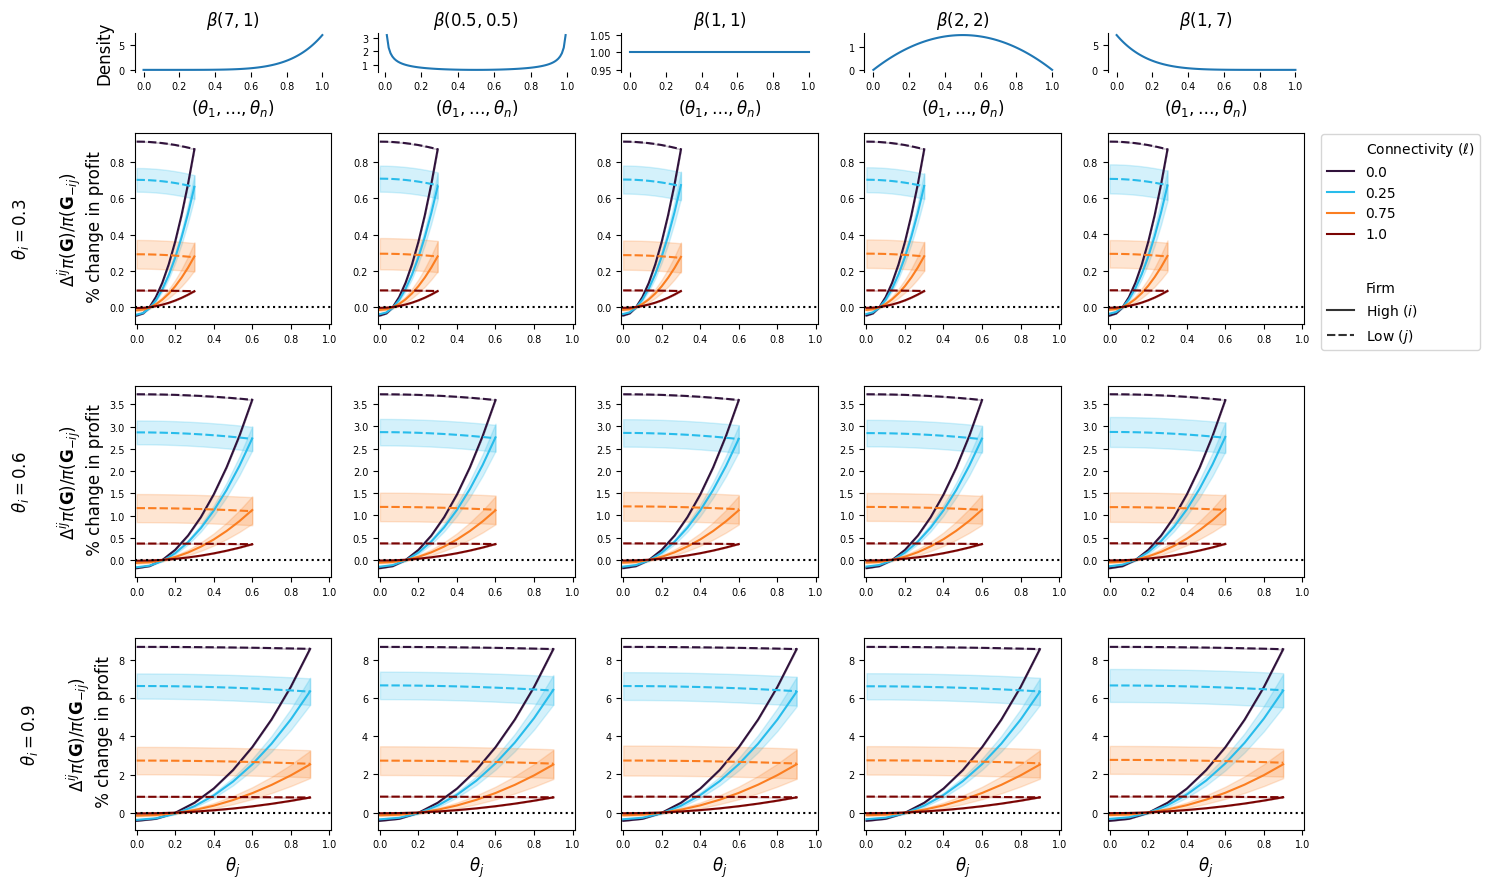

In [ ]:
connectivity_text = 'Connectivity ($\ell$)'
firm_text = '\n\nFirm'

df[connectivity_text] = df['Pr(connect)']
df[firm_text] = df['firm'].map({'i': 'High ($i$)', 'j': 'Low ($j$)'})

ncols = len(setting['dist_params'])
nrows = len((setting['theta_i']))
fig, axs = plt.subplots(
    nrows=nrows + 1, ncols=ncols, 
    figsize=(ncols * 3, nrows * 3), 
    gridspec_kw={'height_ratios': [1] + [5] * nrows}
)

for i, ((alpha, beta)) in enumerate(setting['dist_params']):
    x = np.linspace(0, 1, 100)
    y = sp.stats.beta.pdf(x, a=alpha, b=beta)
    sns.lineplot(x=x, y=y, ax=axs[0, i])
    axs[0, i].set_title(f'$\\beta({alpha}, {beta})$')
    axs[0, i].set_xlabel('$(\\theta_1, \\ldots, \\theta_n)$')
    axs[0, i].spines['right'].set_visible(False)
    axs[0, i].spines['top'].set_visible(False)
    axs[0, i].spines['bottom'].set_visible(False)

for row, theta_i in enumerate(setting['theta_i']):
    df_sub_i = df[df['theta_i'] == theta_i]
    for col, ((alpha, beta)) in enumerate(setting['dist_params']):
        df_sub = df_sub_i[df_sub_i['dist'] == (alpha, beta)]
        sns.lineplot(
            data=df_sub,
            x='theta_j', y='pi_diff',
            style=firm_text, hue=connectivity_text,
            errorbar='sd',
            ax=axs[row + 1, col],
            palette='turbo'
            )
        axs[row + 1, col].axhline(0, ls='dotted', color='black')
        axs[row + 1, col].get_legend().remove()
        axs[row + 1, col].set_ylabel('')
        axs[row + 1, col].set_xlabel('')
        if col == 0:
            axs[row + 1, col].set_ylabel(
                f'$\\theta_i = {theta_i}$\n\n' + '$\\Delta^{ij} \\pi(\mathbf{{G}}) / \\pi(\mathbf{{G}}_{{-ij}})$\n % change in profit'
            )
        else:
            axs[row + 1, col].set_ylabel('')

        axs[row + 1, col].set_xlim(-0.01, 1.01)

for col in range(ncols):
    axs[-1, col].set_xlabel('$\\theta_j$')

axs[1, nrows+1].legend(bbox_to_anchor=(1.05, 1.03))
axs[0, 0].set_ylabel('Density')
plt.tight_layout()
plt.savefig('../Plots/Fic_C_1 random_deviation_theta_v1.pdf', bbox_inches='tight')

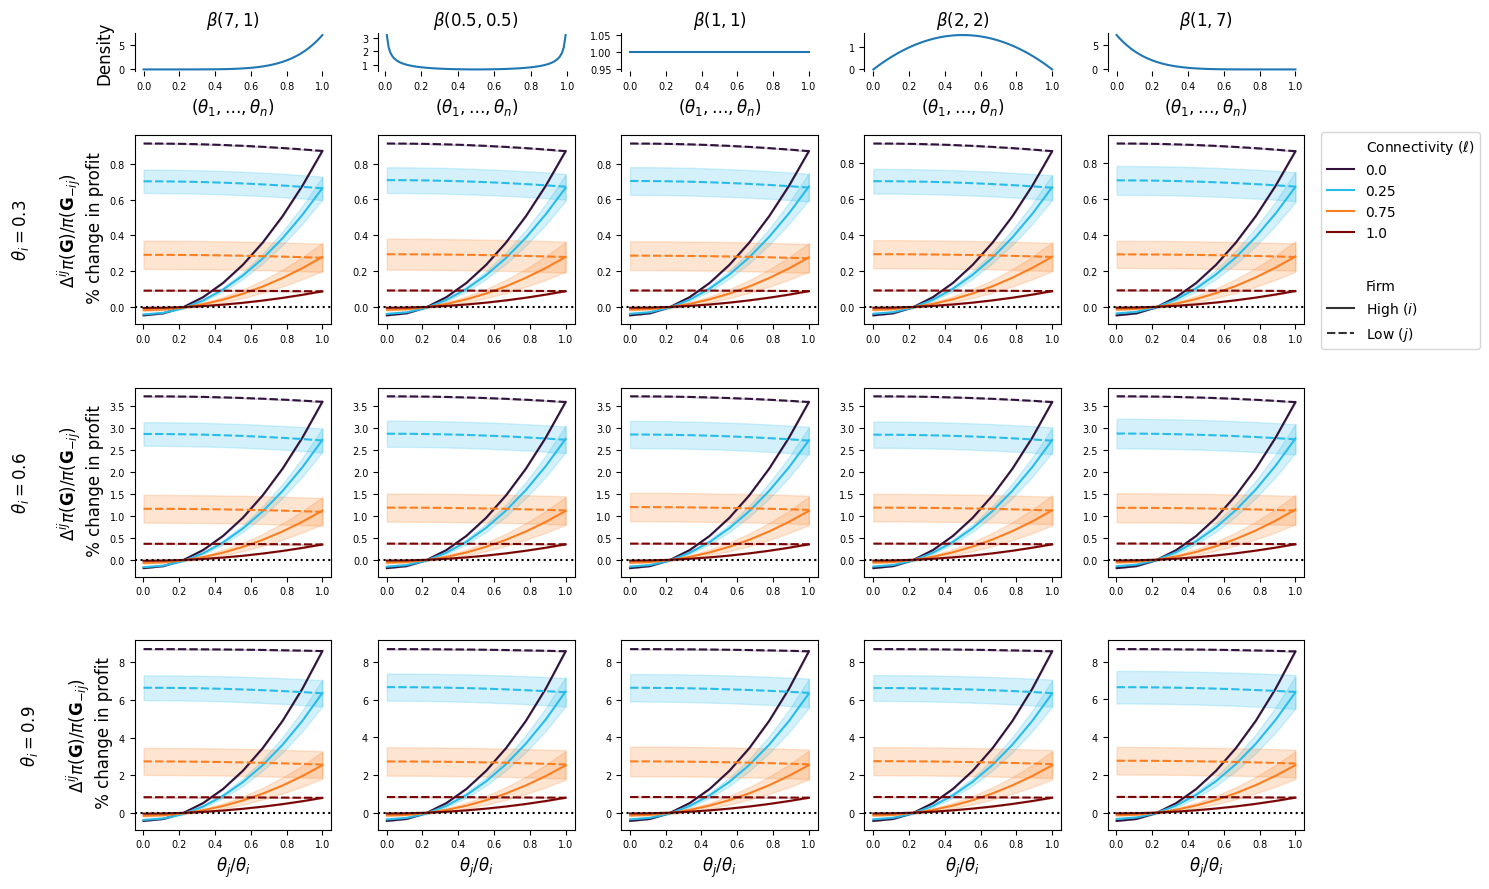

In [ ]:
connectivity_text = 'Connectivity ($\ell$)'
firm_text = '\n\nFirm'

df[connectivity_text] = df['Pr(connect)']
df[firm_text] = df['firm'].map({'i': 'High ($i$)', 'j': 'Low ($j$)'})

ncols = len(setting['dist_params'])
nrows = len((setting['theta_i']))
fig, axs = plt.subplots(
    nrows=nrows + 1, ncols=ncols, 
    figsize=(ncols * 3, nrows * 3), 
    gridspec_kw={'height_ratios': [1] + [5] * nrows}
)

for i, ((alpha, beta)) in enumerate(setting['dist_params']):
    x = np.linspace(0, 1, 100)
    y = sp.stats.beta.pdf(x, a=alpha, b=beta)
    sns.lineplot(x=x, y=y, ax=axs[0, i])
    axs[0, i].set_title(f'$\\beta({alpha}, {beta})$')
    axs[0, i].set_xlabel('$(\\theta_1, \\ldots, \\theta_n)$')
    axs[0, i].spines['right'].set_visible(False)
    axs[0, i].spines['top'].set_visible(False)
    axs[0, i].spines['bottom'].set_visible(False)

for row, theta_i in enumerate(setting['theta_i']):
    df_sub_i = df[df['theta_i'] == theta_i]
    for col, ((alpha, beta)) in enumerate(setting['dist_params']):
        df_sub = df_sub_i[df_sub_i['dist'] == (alpha, beta)]
        sns.lineplot(
            data=df_sub,
            x='theta', y='pi_diff',
            style=firm_text, hue=connectivity_text,
            errorbar='sd',
            ax=axs[row + 1, col],
            palette='turbo'
            )
        axs[row + 1, col].axhline(0, ls='dotted', color='black')
        axs[row + 1, col].get_legend().remove()
        axs[row + 1, col].set_ylabel('')
        axs[row + 1, col].set_xlabel('')
        if col == 0:
            axs[row + 1, col].set_ylabel(
                f'$\\theta_i = {theta_i}$\n\n' + '$\\Delta^{ij} \\pi(\mathbf{{G}}) / \\pi(\mathbf{{G}}_{{-ij}})$\n % change in profit'
            )
        else:
            axs[row + 1, col].set_ylabel('')

for col in range(ncols):
    axs[-1, col].set_xlabel('$\\theta_j/\\theta_i$')

axs[1, nrows+1].legend(bbox_to_anchor=(1.05, 1.05))
axs[0, 0].set_ylabel('Density')
plt.tight_layout()
plt.savefig('../Plots/Fic_C_1 random_deviation_theta_v2.pdf', bbox_inches='tight')